# Script to pre-process exp/sim PACBEDs to train/test CNN

## Simulation:
simulation CBEDs are in unit of beam percentage, keep the unit as it is.
## Experiment:
Experiment collected CBEDs are in unit of intensity counts, which need beam current and gain factor to be converted to beam percentage. Another way is to calculate total intensity from full beam using blank scan, then use this intensity to normalize each image.

In [61]:
import os,glob
import scipy.signal
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import csv
import struct
import skimage
from skimage.transform import rescale, resize, downscale_local_mean

### Process blank scan series

In [3]:
RefPath = '/srv/home/chenyu/DEbackup/091618/BlankScan/'
RefName = 'S0'
rx = 150;
ry = 150;
# sample = np.load(RefPath+'npy/'+RefName+'_'+format(1000,'05')+'.npy')
IntList = np.zeros(rx*ry)
# plt.imshow(sample)
# plt.colorbar()
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        IntList[filenum-1] = np.sum(frame)

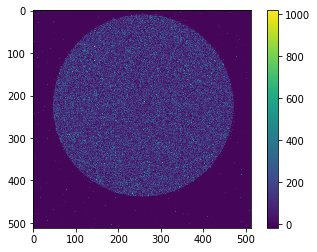

In [141]:
plt.imshow(frame)
plt.colorbar()

Mean intensity is 19675223.944470953, with standard deviation 66397.12229857735.
0.0033746564962090805


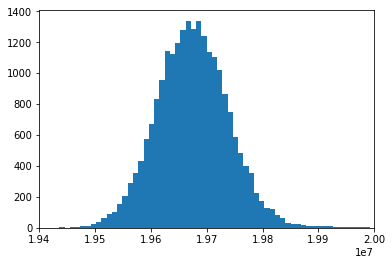

In [143]:
MeanInt = np.mean(IntList[5:-1])
Std = np.std(IntList[5:-1])
print('Mean intensity is ' + str(MeanInt) + ', with standard deviation ' + str(Std) +'.')
print(Std/MeanInt)
plt.hist(IntList[5:-1],100)
plt.xlim([1.94e7,2e7])
plt.show()

### Process experiment PACBED

<font color='red'> **Total beam fraction is too low for some reason, check raw frame and also mask shape. Sample needs to be resized to match simulation pixel amounts **

Total intensity in beam fraction: 0.7895


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


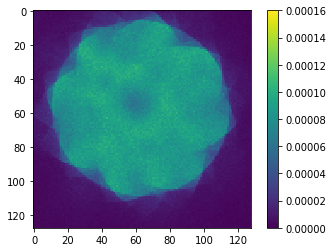

In [133]:
ExpPath = '/srv/home/chenyu/DEbackup/071618/S7/SrPACBED_Stack_R6.mat'
mat_contents = sio.loadmat(ExpPath)
exp = mat_contents['PACBED_stack'][:,:,7]/MeanInt
exp_rescale = rescale(exp, 1.0 / 4.0)
exp_rescale = exp_rescale / np.sum(exp_rescale) * np.sum(exp)
plt.imshow(exp_rescale,clim=[0,0.00016])
plt.colorbar()
print('Total intensity in beam fraction: ' + "{:.4f}".format(np.sum(exp)))

**Test arbitrary single raw frame**

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Total intensity in beam fraction: 0.5828


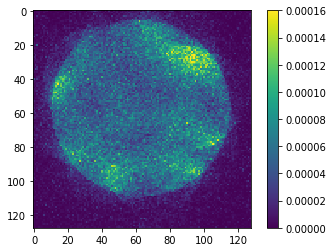

In [75]:
# exp = np.load('/srv/home/chenyu/DEbackup/071618/S7/npy/S7_00099.npy')/MeanInt
exp_rescale = rescale(exp, 1.0 / 4.0)
exp_rescale = exp_rescale / np.sum(exp_rescale) * np.sum(exp)
plt.imshow(exp_rescale,clim=[0,0.00016])
plt.colorbar()
print('Total intensity in beam fraction: ' + "{:.4f}".format(np.sum(exp)))


### Process simulation PACBED from same thickness

In [25]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [121]:
HAADFprediction = '/srv/home/chenyu/DEbackup/071618/S7/HAADFprediction_r8.mat'
mat_contents = sio.loadmat(HAADFprediction)
thickness = mat_contents['peak_int']
out_sz = (16,16,408,408)

source_size = 90
px_size = 20
sigma = (source_size/px_size)/(2.355)

sim_path = '/srv/home/lerandc/outputs/718_STO/0_0/raw_output/'
layer = int(thickness[0]/0.3905)
base_name = 'STO_35nm_0_0_slice' + str(layer-1)
base_ext = '_FPavg.npy'

output = np.zeros(out_sz,dtype=np.float32)
for x in range(out_sz[0]):
    for y in range(out_sz[1]):
        output[x,y,:,:] = np.squeeze(np.load(sim_path+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext))
                
output = np.squeeze(output)
result = np.zeros(out_sz,dtype=np.float32)

kernel = gaussKernel(sigma,out_sz[0])
fkernel = np.fft.fft2(kernel)

for k in range(out_sz[2]):
        for l in range(out_sz[3]):
            #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
            result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output[:,:,k,l]))).real
            
y1,x1 = np.ogrid[-8:8, -8:8]
y2,x2 = np.ogrid[-8:8, -8:8]
mask = x1*x1 + y1*y1 <= 5*5
sim = np.zeros((out_sz[2],out_sz[3]))

for x in range(out_sz[0]):
    for y in range(out_sz[1]):
        if mask[x,y]!=0:
            sim = sim + result[x,y,:,:]

sim = sim/np.sum(sim)

**Total beam fraction sum up to 1 **

Total intensity in beam fraction: 1.0000


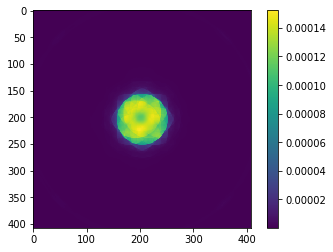

In [69]:
plt.imshow(sim)
plt.colorbar()
print('Total intensity in beam fraction: ' + "{:.4f}".format(np.sum(sim)))

Total intensity in beam fraction: 0.9409


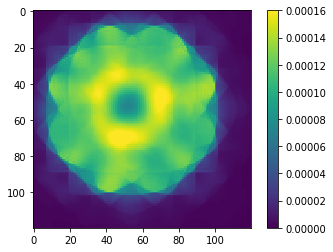

In [122]:
plt.imshow(sim[150:270,150:270],clim=[0,0.00016])
plt.colorbar()
print('Total intensity in beam fraction: ' + "{:.4f}".format(np.sum(sim[150:270,150:270])))

### Process simulated PACBED for CNN training
Start from noiseless STO PACBED under /srv/home/lerandc/outputs/718_STO/0_0/pacbeds/noiseless

0.00015790315
0.8781649
0.8783914


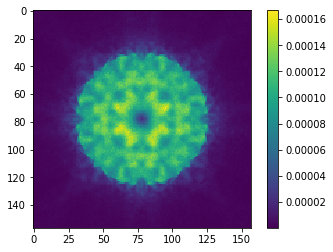

In [93]:
noiseless_path = '/srv/home/lerandc/outputs/718_STO/0_0/pacbeds/noiseless/'
sample = np.load(noiseless_path + 'Sr_PACBED_8_8_5_90.npy')
print(np.max(sample))
noisy = np.random.poisson(sample*10000000)
plt.imshow(noisy/10000000)
plt.colorbar()
print(np.sum(sample))
print(np.sum(noisy/10000000))

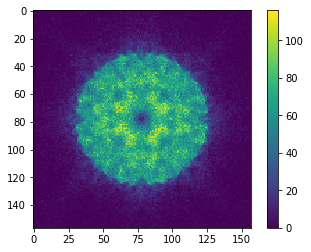

In [111]:
ref = np.load('/srv/home/lerandc/outputs/718_STO/0_0/pacbeds/noise100/Sr_PACBED_8_8_5_90_noise100.npy');
plt.imshow(ref)
plt.colorbar()

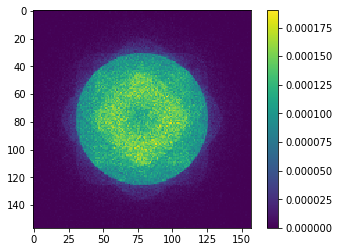

In [109]:
sample = np.load('/srv/home/chenyu/CNN/STO_35nm/0_0/noise10e6/Sr_PACBED_8_8_5_21.npy').astype(dtype=np.float64)
sample = sample.astype(dtype=np.float32)
plt.imshow(sample)
plt.colorbar()